# Bayesian A/B Test

Autor: Luca Honegger, lh@sinnhaft.ch

Quelle: Dies ist eine Python-Portierung der UXtoolbox in R von Mohsen Rafiei, https://github.com/mohsen-rafiei/UXtoolbox

## 🧠 Was macht diese Funktion?

Die Funktion `bayesian_ab_test()` führt einen **Bayesschen A/B-Test** durch.
Sie vergleicht zwei Gruppen (z. B. Variante A vs. Variante B) basierend auf Erfolgen und Gesamtversuchen.

### 🔍 Was wird berechnet?

* Wie wahrscheinlich ist es, dass **A besser abschneidet als B** – und umgekehrt
* Wie hoch ist die **erwartete Erfolgsrate** für A und B
* Wie gross ist der **wahrscheinliche Unterschied** (Credible Interval)

Dabei wird nicht nur ein einfacher Mittelwert verglichen, sondern **Unsicherheit mit einbezogen** – das ist der Vorteil von Bayesian Statistics.

## 🧪 Beispiel aus dem Business-Alltag

Stell dir vor, du testest zwei Versionen einer Landingpage:

* **Variante A:** 65 Conversions bei 90 Besuchern
* **Variante B:** 72 Conversions bei 110 Besuchern (z. B. aus einer kleinen gezielten Kampagne)

Mit `bayesian_ab_test([65, 72], [90, 100])` bekommst du:

* Wie wahrscheinlich es ist, dass **Variante A oder B besser ist**
* Und wie gross der Unterschied **realistisch** sein kann

Das hilft dir bei **datenbasierten Entscheidungen**, auch wenn die Stichprobe klein oder ungleich verteilt ist – typisches Szenario z. B. bei MVP-Tests, Marketing-Kampagnen oder Produktexperimenten.


## `bayesian_ab_test`
mit PyMC

In [2]:
import pymc as pm
import arviz as az
import numpy as np

def bayesian_ab_test(successes, trials, ci=0.95, n_samples=10000):
    """
    Bayesscher A/B-Test mit PyMC.
    Verwendet MCMC, um Posterior-Verteilungen für zwei Binomial-Prozesse zu vergleichen.
    """
    with pm.Model() as model:
        # Priors – Beta(1, 1) ist ein uninformierter Prior (Uniform)
        theta_a = pm.Beta("theta_a", alpha=1, beta=1)
        theta_b = pm.Beta("theta_b", alpha=1, beta=1)

        # Likelihoods
        obs_a = pm.Binomial("obs_a", n=trials[0], p=theta_a, observed=successes[0])
        obs_b = pm.Binomial("obs_b", n=trials[1], p=theta_b, observed=successes[1])

        # MCMC-Sampling
        trace = pm.sample(n_samples, tune=1000, return_inferencedata=True, progressbar=False)

    # Ziehe Posterior-Samples
    samples_a = trace.posterior["theta_a"].values.flatten()
    samples_b = trace.posterior["theta_b"].values.flatten()

    # Berechnungen wie in deiner Originalfunktion
    prob_a_better = float(np.mean(samples_a > samples_b))
    prob_b_better = 1.0 - prob_a_better

    diff = samples_a - samples_b
    lower = float(np.percentile(diff, (1 - ci) / 2 * 100))
    upper = float(np.percentile(diff, (1 + ci) / 2 * 100))

    return {
        "Probability_A": float(np.mean(samples_a)),
        "Probability_B": float(np.mean(samples_b)),
        "Probability_A_Better": prob_a_better,
        "Probability_B_Better": prob_b_better,
        "Credible_Interval": (lower, upper),
        "trace": trace  # optional, falls du noch plotten willst
    }


## Anwendungsbeispiel

In [4]:
# Beispiel
# A = 65 Erfolge, 90 Versuche
# B = 72 Erfolge, 110 Versuche
# Credible Interval = 95%

ci = 0.95
result = bayesian_ab_test([65, 72], [90, 110], ci)

print(f"Wahrscheinlichkeit, dass A erfolgreich ist: {result['Probability_A']:.3f}")
print(f"Wahrscheinlichkeit, dass B erfolgreich ist: {result['Probability_B']:.3f}")

print(f"Wahrscheinlichkeit, dass A besser ist als B: {result['Probability_A_Better']:.3f}")
print(f"Wahrscheinlichkeit, dass B besser ist als A: {result['Probability_B_Better']:.3f}")

print(f"Credible Interval ({ci*100})%: {result['Credible_Interval'][0]:.2f}, {result['Credible_Interval'][1]:.2f}")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_a, theta_b]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 2 seconds.


Wahrscheinlichkeit, dass A erfolgreich ist: 0.718
Wahrscheinlichkeit, dass B erfolgreich ist: 0.652
Wahrscheinlichkeit, dass A besser ist als B: 0.842
Wahrscheinlichkeit, dass B besser ist als A: 0.158
Credible Interval (95.0)%: -0.06, 0.19


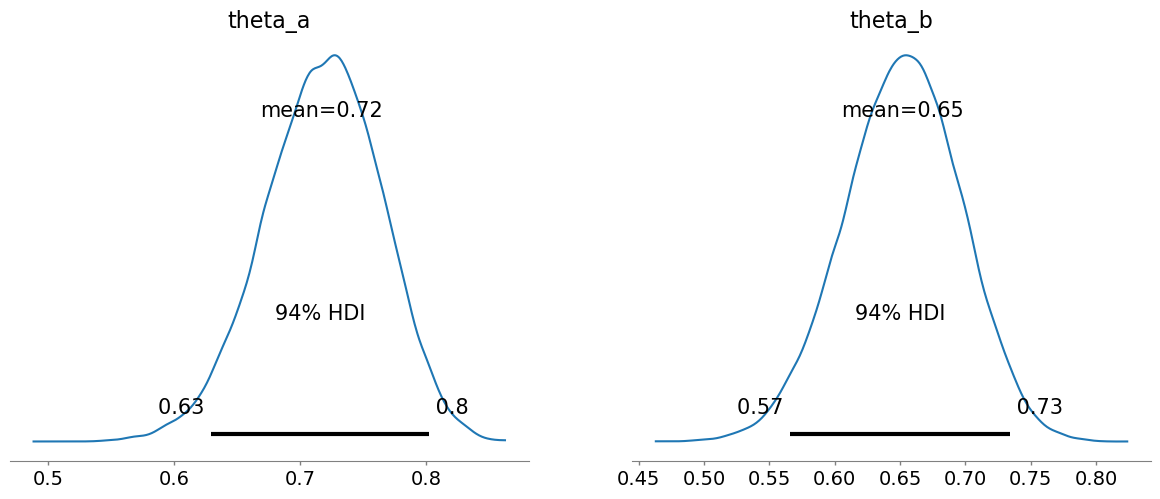

In [9]:
import matplotlib.pyplot as plt

az.plot_posterior(result["trace"], var_names=["theta_a", "theta_b"])
plt.show()

### 📊 Erklärung und Interpretation


#### Kontext der Analyse

* Variante **A**: 65 Erfolge bei 90 Versuchen → Erfolgsrate ≈ 72 %
* Variante **B**: 72 Erfolge bei 110 Versuchen → Erfolgsrate ≈ 65 %

Du möchtest wissen: **Ist A besser als B?**


#### 🧠 Was sagt das Credible Interval?

```
Credible Interval (95%): –0.06, 0.19
```

➡️ Das bedeutet:
Mit **95 % Wahrscheinlichkeit** liegt der wahre Unterschied der Erfolgsraten zwischen **A und B** irgendwo zwischen **–6 Prozentpunkten und +19 Prozentpunkten**.

* Ein **positiver Wert** würde bedeuten: A ist besser als B
* Ein **negativer Wert** würde bedeuten: B ist besser als A


#### ❗️ Interpretation im Beispiel

* Der Wert **0** liegt **innerhalb** des Intervalls → Wir können **nicht sicher** sagen, dass A **wirklich besser** ist.
* Die Wahrscheinlichkeit, dass A besser ist als B liegt zwar bei **84,8 %**, aber es gibt noch **Restunsicherheit**, da das Intervall auch **negative Unterschiede** zulässt.


### 🟡 Fazit

> A **ist wahrscheinlich besser**, aber der Unterschied ist **nicht 100 % sicher**.
> Das **Credible Interval zeigt, wie gross der Unterschied vermutlich ist** – inklusive Unsicherheit.

Das ist eine zentrale Stärke der **Bayesschen Analyse**: Sie zeigt dir **nicht nur, was wahrscheinlich ist**, sondern **wie sicher** du dir sein kannst.
